The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


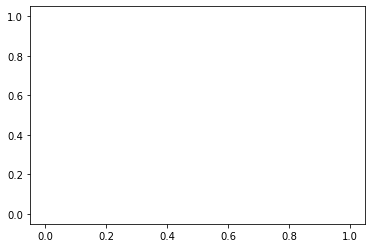

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:24<00:00,  3.20it/s]


tensor(0.9250)


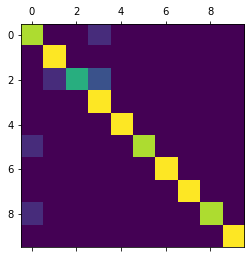

In [3]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

# repository modules
import models
import dataset
import train
import adversarial.pgd as pgd

REPO_ROOT = os.path.join(os.path.dirname(os.path.realpath('__file__')),"..")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/data.pt")

traindata = dataset.FaustDataset(FAUST, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, train=False, test=True,  transform_data=True)
model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    D_t = traindata.downscale_matrices,
    E_t = traindata.downscaled_edges,
    num_classes = traindata.num_classes,
    parameters_file=PARAMS_FILE)

#train network
loss = train.train(
    train_data=traindata,
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=0, #<-------------- change in order to train
    learning_rate=1e-4)
plt.plot(loss)
plt.show()

#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=traindata, classifier=model)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()

In [6]:
import adversarial.pgd as pgd
import numpy as np

def save_adex(adex, y, filename):
  ppos = adex.perturbed_pos.detach().clone().cpu().numpy()
  pos = adex.pos.detach().clone().cpu().numpy()
  edges = adex.edges.detach().clone().cpu().numpy()
  faces = adex.faces.detach().clone().cpu().numpy()
  is_successful = adex.is_successful
  
  data = {"perturbed-positions":ppos,
   "positions":pos,
   "edges":edges,
   "faces":faces,
    "y":y,
    "success":is_successful}
  np.save(filename, data, allow_pickle=True)
    

def FSGM_experiments(projection_type, builder_type, model, data, shape_index):
    """
    Arguments:
    * projection_type: can assume values in ['lowband','lowband-clip','clip']
    * builder_type: use "l2" to use the attack from 'Extending ...', use 'sign' for standard fsgm.
    * model: classifier
    * data: dataset used
    * shape_index: index of shape in data.
    """
    projections = {"lowband":         pgd.lowband_filter,
                  "lowband-clip":     lambda a,x: pgd.clip(a, pgd.lowband_filter(a,x)),
                  "lowband-clipnorm": lambda a,x: pgd.clip_norms(a,pgd.lowband_filter(a,x)),
                   "none":            lambda y,z : z,
                  "clip":             pgd.clip,
                  "clipnorm":         pgd.clip_norms}

    builders = {"sign":(pgd.PGDBuilder,0.005), "l2":(pgd.L2PGDBuilder, 1)}    
    i = shape_index
    x = data[i].pos
    e = data[i].edge_index.t()
    f = data[i].face.t() 
    y = data[i].y

    if model(x).argmax() == y:
        tmp, alpha = builders[builder_type]
        builder = tmp().set_iterations(7).set_epsilon(0.045).set_alpha(alpha).set_eigs_number(50)
        builder.set_projection(projections[projection_type])
        builder.set_mesh(x,e,f).set_classifier(model)
        adex = builder.build(usetqdm="standard")
        print("successful: {}".format(adex.is_successful))
        return adex
    else:
        print("skip")
        
FSGM_experiments("lowband-clip", "sign", model=model, data=testdata, shape_index=0)

successful: True
